In [ ]:
!pip install -U google-cloud
!pip install -U google-cloud-bigquery

In [31]:
%%bq query --name data_week

SELECT
  CONCAT(CAST(EXTRACT(YEAR FROM start_date) AS STRING),'-',LPAD(CAST(EXTRACT(WEEK FROM start_date) AS STRING),2,'0')) hire_week,
  COUNT(rental_id) hire_count
FROM
  `bigquery-public-data.london_bicycles.cycle_hire`
WHERE
  CONCAT(CAST(EXTRACT(YEAR FROM start_date) AS STRING),'-',LPAD(CAST(EXTRACT(WEEK FROM start_date) AS STRING),2,'0')) <= '2017-23'
AND
  EXTRACT(WEEK FROM start_date) !=0
GROUP BY
  hire_week,
ORDER BY 
  hire_week ASC
;

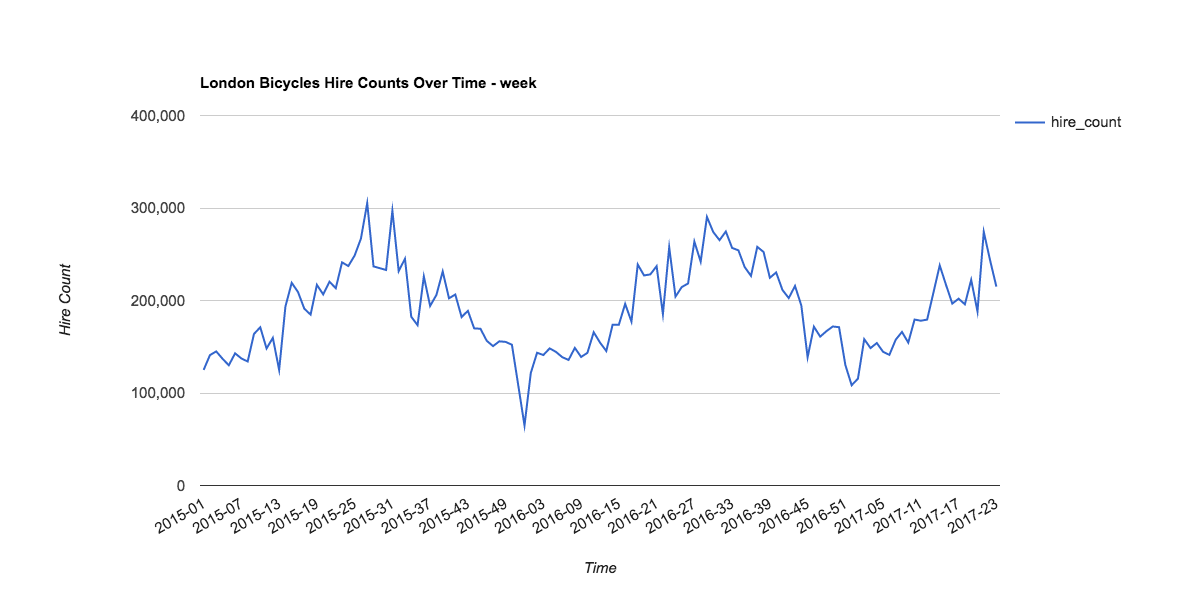

In [32]:
%chart line --data data_week --fields hire_week,hire_count
title: London Bicycles Hire Counts Over Time - week
height: 600
width: 1200
hAxis:
  title: Time
vAxis:
  title: Hire Count

### Experiment:

* Granularity: Week

* Train data: 2015-01: 2016-26 (78 weeks: 1.5 cycles)

* Eval  data: 2016-26: 2016-52 (26 weeks: 0.5 cycle)

* Test  data: 2017-01: 2017-23 (23 weeks: < 0.5 cycle)

### Baseline Simple linear regression (ignoring temporal autocorrelation)

In [ ]:
%%bq query 

CREATE OR REPLACE TABLE bqml_ts.cycles_hire_simple_data
AS
  SELECT 
    ROW_NUMBER() OVER(ORDER BY hire_week) time_index,
    hire_count value
  FROM
  (
    SELECT  
      CONCAT(CAST(EXTRACT(YEAR FROM start_date) AS STRING),'-',LPAD(CAST(EXTRACT(WEEK FROM start_date) AS STRING),2,'0')) hire_week,
      COUNT(rental_id) hire_count
    FROM
      `bigquery-public-data.london_bicycles.cycle_hire`
    WHERE
      CONCAT(CAST(EXTRACT(YEAR FROM start_date) AS STRING),'-',LPAD(CAST(EXTRACT(WEEK FROM start_date) AS STRING),2,'0')) <= '2017-23'
    AND
      EXTRACT(WEEK FROM start_date) !=0
    GROUP BY
      hire_week
  )
;

In [ ]:
%%bq query

CREATE OR REPLACE VIEW bqml_ts.learn_data
AS
  SELECT 
    time_index,
    time_index as time_index_split,
    value
  FROM
    `ksalama-gcp-playground.bqml_ts.cycles_hire_simple_data`
  WHERE
    time_index <= 104 #train and evaluate using the weeks of 2015 and 2016, leaving 2017 weeks for testing
;

In [35]:
%%bq query

CREATE OR REPLACE VIEW bqml_ts.test_data
AS
  SELECT 
    time_index,
    time_index as time_index_split,
    value
  FROM
    `ksalama-gcp-playground.bqml_ts.cycles_hire_simple_data`
  WHERE
    time_index > 104 #train and evaluate using the weeks of 2015 and 2016, leaving 2017 weeks for testing
;

In [ ]:
%%bq query 

CREATE OR REPLACE MODEL bqml_ts.simple_model
OPTIONS
  ( 
    model_type='linear_reg', 
    input_label_cols=['value'],
    data_split_method='seq',
    data_split_col='time_index_split',
    data_split_eval_fraction=0.25
)
AS
  SELECT *
  FROM bqml_ts.learn_data
  

In [37]:
%sql --module query 

SELECT
  time_index,
  value,
  predicted_value
FROM
  ml.PREDICT(
    model bqml_ts.simple_model,
    (SELECT * FROM bqml_ts.learn_data)
  )
ORDER BY
  time_index ASC

In [38]:
import datalab.bigquery as bq
import sys
results = bq.Query(query).to_dataframe(dialect='standard')
results.head(5)

,time_index,value,predicted_value
0,1,124964,182455.633630
1,2,140935,182488.884278
2,3,144970,182522.134926
3,4,137036,182555.385573
4,5,129965,182588.636221


In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

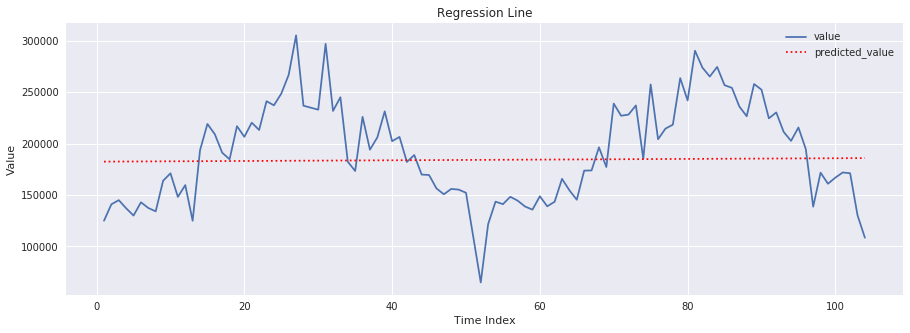

In [40]:
plt.close('all')
plt.figure(figsize=(15, 5))

plt.subplot(1,1,1)
plt.title("Regression Line")
plt.plot(results.time_index, results.value)
plt.plot(results.time_index, results.predicted_value, ':r')
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
# --

In [41]:
%%bq query 
SELECT *
FROM ml.EVALUATE(
  model bqml_ts.simple_model,
  (SELECT * FROM bqml_ts.test_data)
)

mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
30696.6683748,1383313254.17,0.0407162705887,28512.2048757,0.0100580413364,0.0101134266784


## Linear regression model with Fourier Transformations

In [ ]:
%%bq query 

CREATE OR REPLACE TABLE bqml_ts.cycles_hire_extended_data
AS

WITH query_a
AS
(
  SELECT 
    ROW_NUMBER() OVER(ORDER BY hire_week) time_index,
    week_number,
    hire_count value
  FROM
  (
    SELECT  
      EXTRACT(WEEK FROM start_date) week_number,
      CONCAT(CAST(EXTRACT(YEAR FROM start_date) AS STRING),'-',LPAD(CAST(EXTRACT(WEEK FROM start_date) AS STRING),2,'0')) hire_week,
      COUNT(rental_id) hire_count
    FROM
      `bigquery-public-data.london_bicycles.cycle_hire`
    WHERE
      CONCAT(CAST(EXTRACT(YEAR FROM start_date) AS STRING),'-',LPAD(CAST(EXTRACT(WEEK FROM start_date) AS STRING),2,'0')) <= '2017-23'
    AND
      EXTRACT(WEEK FROM start_date) !=0
    GROUP BY
      hire_week,
      week_number
  )
)

SELECT 
  time_index,
  value,
  week_number,
  LAG(value,1) OVER (order by time_index) as prev_value_1,
  LAG(value,2) OVER (order by time_index) as prev_value_2,
  LAG(value,3) OVER (order by time_index) as prev_value_3,
  LAG(value,26) OVER (order by time_index) as prev_value_26,
  LAG(value,52) OVER (order by time_index) as prev_value_52,
  cos(week_number * 2* 3.14159 * 1/52) AS freq_cos_1,
  cos(week_number * 2* 3.14159 * 3/52) AS freq_cos_3,
  cos(week_number * 2* 3.14159 * 5/52) AS freq_cos_5,
  cos(week_number * 2* 3.14159 * 7/52) AS freq_cos_7
FROM
  query_a
;

In [ ]:
%%bq query

CREATE OR REPLACE VIEW bqml_ts.learn_data_extended
AS
  SELECT 
    time_index,
    time_index as time_index_split,
    value,
    prev_value_1,
    prev_value_2,
    prev_value_3,
    prev_value_26,
    prev_value_52,
    freq_cos_1,
    freq_cos_3,
    freq_cos_5,
    freq_cos_7
  FROM
    `ksalama-gcp-playground.bqml_ts.cycles_hire_extended_data`
  WHERE
    time_index <= 104 #train and evaluate using the weeks of 2015 and 2016, leaving 2017 weeks for testing
;

In [ ]:
%%bq query

CREATE OR REPLACE VIEW bqml_ts.test_data_extended
AS
  SELECT 
    time_index,
    time_index as time_index_split,
    value,
    prev_value_1,
    prev_value_2,
    prev_value_3,
    prev_value_26,
    prev_value_52,
    freq_cos_1,
    freq_cos_3,
    freq_cos_5,
    freq_cos_7
  FROM
    `ksalama-gcp-playground.bqml_ts.cycles_hire_extended_data`
  WHERE
    time_index > 104 #train and evaluate using the weeks of 2015 and 2016, leaving 2017 weeks for testing
;

In [ ]:
%%bq query 

CREATE OR REPLACE MODEL bqml_ts.extended_model
OPTIONS
  ( 
    model_type='linear_reg', 
    input_label_cols=['value'],
    data_split_method='seq',
    data_split_col='time_index_split',
    data_split_eval_fraction=0.25
)
AS
  SELECT *
  FROM bqml_ts.learn_data_extended
  

In [112]:
%sql --module query 

SELECT
  time_index,
  value,
  predicted_value
FROM
  ml.PREDICT(
    model bqml_ts.extended_model,
    (SELECT * FROM bqml_ts.learn_data_extended)
  )
ORDER BY
  time_index ASC

In [113]:
import datalab.bigquery as bq
import sys
results = bq.Query(query).to_dataframe(dialect='standard')
results.head(5)

,time_index,value,predicted_value
0,1,124964,117470.890985
1,2,140935,109820.686051
2,3,144970,111061.870940
3,4,137036,122735.886410
4,5,129965,124570.413827


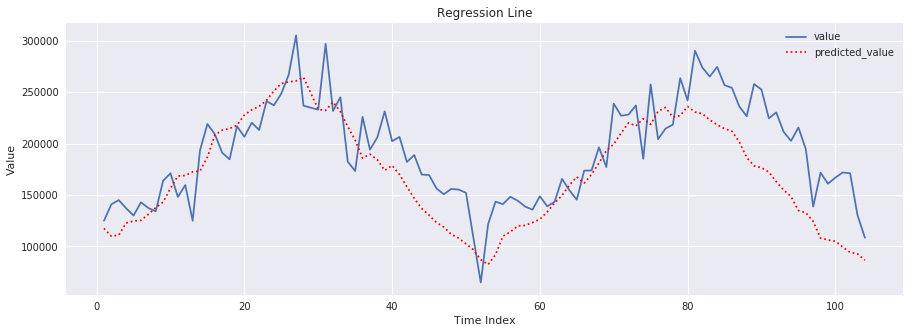

In [114]:
plt.close('all')
plt.figure(figsize=(15, 5))

plt.subplot(1,1,1)
plt.title("Regression Line")
plt.plot(results.time_index, results.value)
plt.plot(results.time_index, results.predicted_value, ':r')
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()

In [115]:
%%bq query 
SELECT *
FROM ml.EVALUATE(
  model bqml_ts.extended_model,
  (SELECT * FROM bqml_ts.test_data_extended)
)

mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
38742.0504299,1891635270.77,0.0882115331236,38929.6504737,-0.353712992617,0.646565401887
